# Homework4 [Project] 
#### Data Science in Korea University, Prof. Jaewoo Kang
#### COSE471, Spring 2018
#### Due : 6/26 (Tues)  11:59 PM [NO LATE HAND IN(Late hand in will get 0), because of school grade policy]

### In this assignment, you will design, implement, and evaluate the appropriate models for given data.
- __This is project assignment. We can not reply your questions about technical(code) issues.__
- __이번 과제는 프로젝트 과제입니다. 소스코드와 같은 기술적인 질문에는 답변 드릴 수 없습니다.__

<br>
<br>
*Perform the steps described below for each dataset(2 Project).*
>0. Preprocess; normalization, feature selection, etc.
>1. Model selection; characteristics of datasets need to be comprehended.
>2. Evaluation; This step should be done properly to prevent overfitting problem.
>3. Enhancement; parameter tuning and feature selection, etc.

### When you make your model for this Project, you should use scikit learn. Don't use other ML package.
### Of course you can use any packages for handling your data. (pandas, numpy, matplotlib, random etc.)
### Download your data in *https://www.dropbox.com/sh/6s4e0z9fhenfw6z/AADkJO3Z6WN1b8IJhkVp9KgDa?dl=0*

## Project 1
### h1b data [h1b_train, h1b_dev, h1b_test]

- Use h1b __train data__ for train your model.
- Tune your model with __dev data__.
- Finally check your best performed model score with __test data__.
- __*You should clean your train dev test data first!!*__
- Score function : Accuracy
<br>
<br>
- __Your goal is to predict CASE_STATUS, using other features.__
- You can choose the features you want to use in your project.

### Attribute Information

- __CASE_STATUS__
    - The CASE_STATUS field denotes the status of the application after LCA processing. Certified applications are filed with USCIS for H-1B approval.
<br>
<br>
- EMPLOYER_NAME
    - Name of the employer submitting labor condition application.
<br>
<br>
- SOC_NAME
    - Occupational name associated with the SOC_CODE. SOC_CODE is the occupational code associated with the job being requested for temporary labor condition, as classified by the Standard Occupational Classification (SOC) System.
<br>
<br>
- JOB_TITLE
    - Title of the job.
<br>
<br>
- FULL_TIME_POSITION
    - Y = Full Time Position; N = Part Time Position.
<br>
<br>
- PREVAILING_WAGE
    - Prevailing Wage for the job being requested for temporary labor condition. The wage is listed at annual scale in USD. The prevailing wage for a job position is defined as the average wage paid to similarly employed workers in the requested occupation in the area of intended employment. The prevailing wage is based on the employer’s minimum requirements for the position.
<br>
<br>
- YEAR
    - Year in which the H-1B visa petition was filed.
<br>
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [211]:
def h1bDataPreprocess(h1bfilename):
    h1b_csv = pd.read_csv(h1bfilename, sep=',') #,index_col=0)
    h1b_csv = h1b_csv.drop_duplicates().iloc[:,:9] # 중복 데이터 삭제 및 위도, 경도 col 삭제 # 중복 데이터가 없긴하다.
    h1b_csv = h1b_csv.dropna() 
    h1b_city, h1b_state = h1b_csv['WORKSITE'].str.split(',').str # Worksite의 city, state를 나눠서 state만을 이용하자.
    #53개주 NA는 삭제 안해도 되나? 해야할꺼 같긴한데 굳이 안없애도 되려나?
    h1b_csv = pd.concat([h1b_csv , h1b_state.to_frame()] ,axis = 1).drop('WORKSITE',axis=1)
    
    # 연관된 두 데이터 중 SOC_NAME에 비해 JOB_TITLE이 너무 많으므로 나중에 one hot encoding 할꺼면 JOB_TITLE 드랍하고 조금이나마 작은 SOC_NAME으로 진행하자.
    h1b_csv = h1b_csv.drop('JOB_TITLE',axis=1)
    
    # SOC_NAME 다 uppercase로 바꾸고, 몇개 없는거는 지우자.
    SOC_NAME = h1b_csv['SOC_NAME'].str.upper().to_frame()
    h1b_csv = h1b_csv.drop('SOC_NAME', axis=1)
    h1b_csv = pd.concat([h1b_csv , SOC_NAME], axis = 1)

    
    # 이제 남은 일들 
    #0. case_status에서 수 적은거랑 withdrawn(이거는 자기가 취소한거) 버리기
    to_drop = ["WITHDRAWN","INVALIDATED","REJECTED","PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED"]
    h1b_csv = h1b_csv[~h1b_csv['CASE_STATUS'].isin(to_drop)]
    h1b_csv.index = range(len(h1b_csv['CASE_STATUS']))
    
    #여기에서 case_status 1,0으로 바꾸기
    denied_index_list = h1b_csv[h1b_csv['CASE_STATUS'] == 'DENIED'].index.tolist()
    certified_index_list = h1b_csv[h1b_csv['CASE_STATUS']=='CERTIFIED'].index.tolist()
    certified_withdrawn_index_list = h1b_csv[h1b_csv['CASE_STATUS']=='CERTIFIED-WITHDRAWN'].index.tolist()

    h1b_csv['CASE_STATUS'][denied_index_list] = 0
    h1b_csv['CASE_STATUS'][certified_index_list] = 1
    h1b_csv['CASE_STATUS'][certified_withdrawn_index_list] = 1

    # 1.이후에 class의 비율에 맞게 데이터를 샘플링하여 class를 밸런스드 하게 해주자. 
    # sampling 구글링 해봐야 될 듯.
    #정 안되면 split이용하면 되겠다.
    
#   h1b_csv['CASE_STATUS'].value_counts() # 비율이 30:1 이니까 0.03프로만 뽑자.
    h1b_csv2 = pd.concat([h1b_csv[h1b_csv['CASE_STATUS'] == 1].sample(frac = 0.034) , h1b_csv[h1b_csv['CASE_STATUS'] == 0]], axis=0)
    h1b_csv2.index = range(len(h1b_csv2['CASE_STATUS']))
    h1b_csv2['CASE_STATUS'] = h1b_csv2['CASE_STATUS'].astype(int)

    #     # soc_name_count 가 500이하인거는 버리자. # 나중에 성능체크할 때 이 값바꿔보자.
    SOC_NAME_VALUE_COUNTS = h1b_csv2['SOC_NAME'].value_counts()
    SOC_NAME_COUNT_list = []
    for i in h1b_csv2['SOC_NAME']:
        SOC_NAME_COUNT_list.append(SOC_NAME_VALUE_COUNTS[i])
    h1b_csv2 = h1b_csv2.assign(SOC_NAME_COUNT = SOC_NAME_COUNT_list)
    h1b_csv2 = h1b_csv2[h1b_csv2['SOC_NAME_COUNT'] > 5] 
    grouped_by_soc_name = h1b_csv2.groupby('SOC_NAME',axis=0)
    soc_name_successRate = grouped_by_soc_name.mean()['CASE_STATUS']

    # certified 확률로 해주자.
    successRate_list = []
    for i in h1b_csv2['SOC_NAME']:
        successRate_list.append(soc_name_successRate[i])
    h1b_csv2 = h1b_csv2.assign(SOC_NAME_SUCCESS_RATE = successRate_list)
    h1b_csv2.index = range(len(h1b_csv2))


    #1. SOC NAME, SOC_NAME_COUNT 드랍하기
    h1b_csv2 = h1b_csv2.drop('SOC_NAME',axis=1)
    h1b_csv2 = h1b_csv2.drop('SOC_NAME_COUNT',axis=1)
    h1b_csv2.index = range(len(h1b_csv2['SOC_NAME_SUCCESS_RATE']))


    # 2.employer name은 어떻게 할지 고민하기 여기에서도 수적은거 버리고 encoding 할까? ㄴㄴ 그냥 버리자. gain ratio 따져보고 버리면 좋긴한데...'
    # h1bTrain_tsv2['EMPLOYER_NAME'].value_counts()
    h1b_csv2 = h1b_csv2.drop('EMPLOYER_NAME',axis = 1) # 근데 이전에 궁금한건 이 이전에 중복된 데이터들은 각자 다른 데이터들인가? ㅇㅇ 모두 id가 다르다!

    # 3.prevaling_wage power distribution이니까 log 취해주기. normalize도 해줄까? 자꾸 에러가 발생하는 것 같아서 안하기로.
#     wage_zero_index = h1b_csv2['PREVAILING_WAGE' == 0].index
#     h1b_csv2['PREVAILING_WAGE'][wage_zero_index] = 1 
#     h1b_csv2['PREVAILING_WAGE'] = np.log(h1b_csv2['PREVAILING_WAGE'])
#     h1b_csv2['PREVAILING_WAGE'] = h1b_csv2['PREVAILING_WAGE'].fillna(h1b_csv2['PREVAILING_WAGE'].mean())
# #         # h1bTrain_tsv2['PREVAILING_WAGE'].describe()
#     h1b_csv2 = h1b_csv2.dropna()

        # 4.label을 뺸 모든 attribute의 gainratio 따져보고 gain ratio가 적은거는 드랍하기
        # 이거도 할지 말지 고민... 우선 구글링해보기

        # 5.wage빼고 전부 one hot encoding
    h1b_csv2 = h1b_csv2.drop('Unnamed: 0',axis=1)
#     SOC_NAME_ENCODED = pd.get_dummies(h1b_csv2.iloc[:,-1])
    # 이렇게 하면 안됨. 500 짤리는게 그때 그때 달라버림. dev이런데에서 열의 개수가 달라진다! 
    
    YEAR_ENCODED = pd.get_dummies(h1b_csv2.iloc[:,-2])
    FULL_TIME_ENCODED = pd.get_dummies(h1b_csv2.iloc[:,-4])

    h1b_csv3 = h1b_csv2.drop(['YEAR','FULL_TIME_POSITION'],axis=1)
    h1b_csv3 = pd.concat([h1b_csv3,YEAR_ENCODED, FULL_TIME_ENCODED],axis=1)

    xtrain = h1b_csv3.iloc[:,1:]
    ytrain = h1b_csv3.iloc[:,0].to_frame() # 아 certified 1,0으로 바꿔줘야할 듯.

    return xtrain, ytrain

In [212]:
# from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# 이 둘 중에 하나 일듯.


Xtrain, Ytrain = h1bDataPreprocess('h1b_train.csv')
# type(Ytrain)

C:\Users\kwakinmo\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kwakinmo\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [213]:
DT = DecisionTreeClassifier(criterion='entropy',min_samples_leaf=4)
DT.fit(np.array(Xtrain),Ytrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [214]:
# # validation에 대해서도 train과 같은 똑같은 데이터 처리를 한다. 
Xdev, Ydev = h1bDataPreprocess('h1b_dev.csv')

C:\Users\kwakinmo\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kwakinmo\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [215]:
DTdevScore = DT.score(np.array(Xdev),Ydev)#TODO
print ("Model dev Accuracy: %f" % DTdevScore)
# #파라미터 값을 수정해나가면서 괜찮은 성능을 구한다.  criterion='entropy', min_samples_leaf = 4
# 파라미터 값 수정하는거랑 SOC_NAME이랑 EMPLOYER_NAME 중에서 success rate만들어주는거랑 해야할듯!

Model dev Accuracy: 0.640438


In [216]:
# # 이를 가지고 최종 testing을 구한다.
Xtest, Ytest = h1bDataPreprocess('h1b_test.csv')
DTtestScore = DT.score(np.array(Xtest),Ytest)
print ("Model test Accuracy: %f" % DTtestScore)

# # plot.confusion_matrix(y, tree.predict(trainingData))

C:\Users\kwakinmo\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kwakinmo\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Model test Accuracy: 0.640023


In [121]:
#RF로도 해봐야지!
# from sklearn.regress

RF = RandomForestClassifier()
RF.fit(np.array(Xtrain),Ytrain)

# 1번문제는 overfit 문제를 해결하기 위해, CV를 이용하는 것이 아니라 dataset을 나누는 것을 이용한다!!
# testscores = cross_val_score(RF, Xdev, Ydev)
# testscores.mean()

#dev 데이터를 preprocess 이를 이용해 validation을 해가면서, 파라미터 값, feature selection 튜닝. 
#feature selection 좋게 해주는 gain ratio 같은 거 있는지 알아보고, 없으면 내가 괜찮다 싶은 것들 계속 넣어보기.

#test 데이터를 preprocess. 이를 이용해서 Accuracy 함수로 testing하여 모델의 best score를 찾을 것. 

C:\Users\kwakinmo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [122]:
RFdevScore = RF.score(np.array(Xdev),Ydev)#TODO
print ("Model dev Accuracy: %f" % RFdevScore)

Model dev Accuracy: 0.643474


In [123]:
RFtestScore = RF.score(np.array(Xtest),Ytest)
print ("Model test Accuracy: %f" % RFtestScore)

Model test Accuracy: 0.649828


## Project 2
### AAAI Accepted Papers

- Cluster papers using AAAI Accepted Papers data [use __'title'__ as primary key].
- Visualize your clustering result and explain it.
<br>
<br>
- __Your goal is to show clustering result with AAAI Accepted Papers.__
- __You must use 'abstract' feature.__ 
- You can choose the features you want to use in your project.

### Attribute Information

- __Title__
    - Free text; title of the paper 
<br>
<br>
- Groups
    - Categorical; author-selected, high-level keyword(s) 
<br>
<br>
- Keywords
    - Free text; author-generated keywords 
<br>
<br>
- Topics
    - Free text; author-selected, low-level keywords 
<br>
<br>
- __Abstracts__
    - Free text; paper abstracts

In [376]:
AAAIcsv = pd.read_csv('AAAI_Accepted_Papers.csv', encoding = "ISO-8859-1", sep=',')
AAAIcsv

,title,groups,keywords,topics,abstract
0,The cascade auction ??a mechanism for deterrin...,Mediators\nAuctions\nCollusion\nAd Exchanges,Multiagent Systems,Auctions and Market-Based Systems\nE-Commerce\...,We introduce a sealed bid auction of a single ...
1,Basis Adaptation for Sparse Nonlinear Reinforc...,Reinforcement learning\nSparsity\nMirror desce...,Machine Learning\nReasoning under Uncertainty,Dimension Reduction/Feature Selection\nOnline ...,This paper presents a new approach to basis ad...
2,Optimal Coalition Structures in Cooperative Gr...,Cooperative Game Theory\nCoalition Structure G...,Multiagent Systems,Coordination and Collaboration\nGame Theory,Representation languages for coalitional game...
3,External Memory Best-First Search for Multiple...,External-Memory Search\nParallel Search\nMulti...,Heuristic Search and Optimization,Heuristic Search\nEvaluation and Analysis (Sea...,Multiple sequence alignment (MSA) is a central...
4,Posted Prices Exchange for Display Advertising...,Display Advertising\nDynamic Pricing\nMarket E...,Multiagent Systems,Auctions and Market-Based Systems\nE-Commerce\...,We propose a new market design for display adv...
5,Gradient Networks for Shape-Based Object Insta...,object detection\ninstance detection\nshape\ng...,Robotics,"Vision, Object Recognition, and Perception",We present a novel framework for shape-based t...
6,Unified Constraint Propagation on Multi-View Data,pairwise constraint propagation\nsemi-supervis...,Machine Learning,Relational/Graph-Based Learning\nSemisupervise...,This paper presents a unified framework for in...
7,Progression of Decomposed Situation Calculus T...,reasoning about actions\ndecomposition of logi...,Knowledge Representation and Reasoning,"Action, Change, and Causality",In many tasks related to reasoning about conse...
8,How to Cut a Cake Before the Party Ends,Cake cutting\nFair division\nComputational soc...,Multiagent Systems,Mechanism Design\nSocial Choice / Voting,For decades researchers have struggled with th...
9,Reciprocal Hash Tables for Nearest Neighbor Se...,locality sensitive hashing\nnearest neighbor s...,Heuristic Search and Optimization\nKnowledge-B...,Search (General/Other)\nInformation Retrieval\...,Recent years have witnessed the success of has...


In [377]:
AAAIcsv['groups'].value_counts()

Novel Machine Learning Algorithms (NMLA)                                                                                                                              50
Game Theory and Economic Paradigms (GTEP)                                                                                                                             29
Knowledge Representation and Reasoning (KRR)                                                                                                                          19
AI and the Web (AIW)                                                                                                                                                  18
Machine Learning Applications (MLA)\nNovel Machine Learning Algorithms (NMLA)                                                                                         16
Game Theory and Economic Paradigms (GTEP)\nMultiagent Systems (MAS)                                                                                        

In [378]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [379]:
for i in range(len(AAAIcsv['title'])):
    AAAIcsv['abstract'][i] = AAAIcsv['abstract'][i].replace('\n'," ")
    AAAIcsv['topics'][i] = pd.Series(AAAIcsv['topics'][i]).replace('\n'," ")
    AAAIcsv['keywords'][i] = AAAIcsv['keywords'][i].replace('\n'," ")
    AAAIcsv['groups'][i] = pd.Series(AAAIcsv['groups'][i]).replace('\n'," ")
    AAAIcsv['title'][i] = str(AAAIcsv['title'][i]) + " " + str(AAAIcsv['abstract'][i]) + " " + str(AAAIcsv['keywords'][i]) + " " + str(AAAIcsv['keywords'][i]) + " " + str(AAAIcsv['keywords'][i]) +" " + str(AAAIcsv['topics'][i])
    # # type(AAAIcsv['topics'][0])

# AAAIcsv['abstract'].value_counts()
# AAAIcsv['topics'].value_counts()

# AAAIcsv['title']
# type(title)
# abstract = AAAIcsv.iloc[:,4]
# data = pd.concat([title.to_frame(), abstract.to_frame()],axis =1)
# # col = ['title', 'abstract']
# # filteredAAAIcsv = AAAIcsv[AAAIcsv.isin(col)]
# # filteredAAAIcsv
data = AAAIcsv['title']
# AAAIcsv['abstract'][0].replace('\n',' ')
# data = AAAIcsv.iloc[:,0]
# print(data[1])

In [380]:
tfidf_vectorizer = TfidfVectorizer()#TODO # 여기 파라미터 뭐 안해도 되려나??
tfidf_matrix = tfidf_vectorizer.fit_transform(data)  #TODO
tfidf_matrix

<548x7111 sparse matrix of type '<class 'numpy.float64'>'
	with 57285 stored elements in Compressed Sparse Row format>

In [381]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters, max_iter=1000)#TODO
#TODO
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
print(clusters[:10])

[0, 1, 0, 2, 0, 2, 1, 2, 0, 2]


In [382]:
#USE THIS -DO NOT CHANGE-
dist = 1 - cosine_similarity(tfidf_matrix)
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'} #,3: 'blue'}#, 3: 'blue'}
categories = [ 'clus1', 'clus2','clus3'] #, 'clus4']#,'clus4' ]
cluster_names = categories

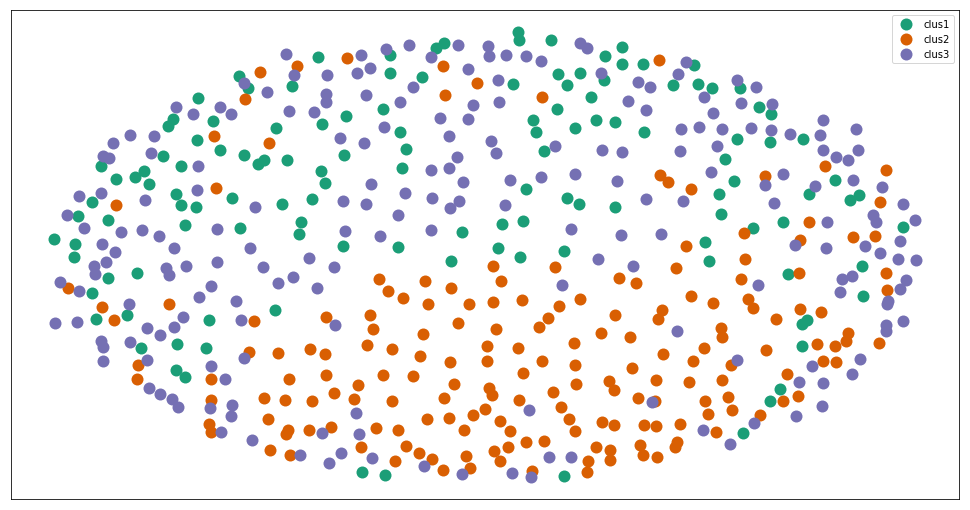

In [383]:
def visualize_clusters(xs, ys, clusters, cluster_names, cluster_colors):
    %matplotlib inline 
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
    groups = df.groupby('label')##TODO  // (name => 0,x값,y값) 이렇게 그루핑됨
    fig, ax = plt.subplots(figsize=(17, 9))
    ax.margins(0.05) 
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
                label= cluster_names[name],#TODO 
                color= cluster_colors[name],#TODO, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          
            which='both',      
            bottom='off',      
            top='off',         
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         
            which='both',     
            left='off',     
            top='off',      
            labelleft='off')
    ax.legend(numpoints=1) 
    plt.show() 

visualize_clusters(xs, ys, clusters, cluster_names, cluster_colors)

# FIN
## You did a really good job for the short semester. Have a nice vacation!! :) 